
Linear Regression
Train RMSE: 0.3079284984297009
Test RMSE: 2.0097461438153617
R2 Score: -1.080144235654945

Random Forest
Train RMSE: 0.4581298987874671
Test RMSE: 1.2122077211264712
R2 Score: 0.24322786357096549


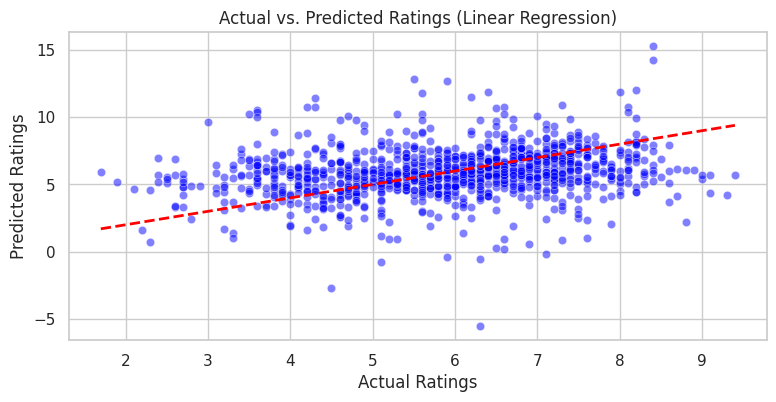

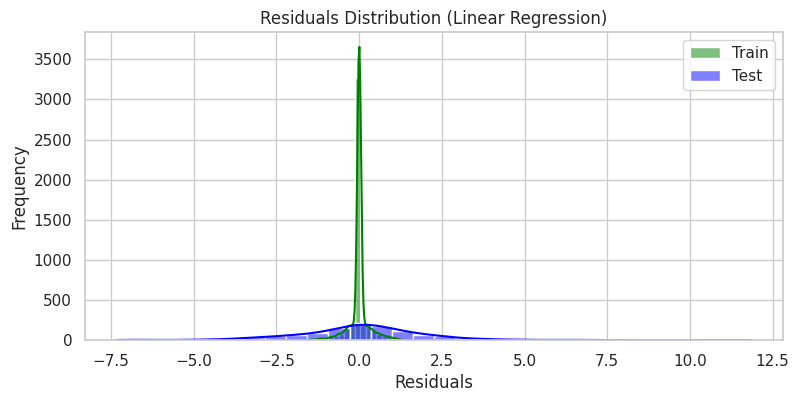

<ipython-input-1-b5b2e0312bdd>:107: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[residuals_train, residuals_test], palette=['green', 'blue'])


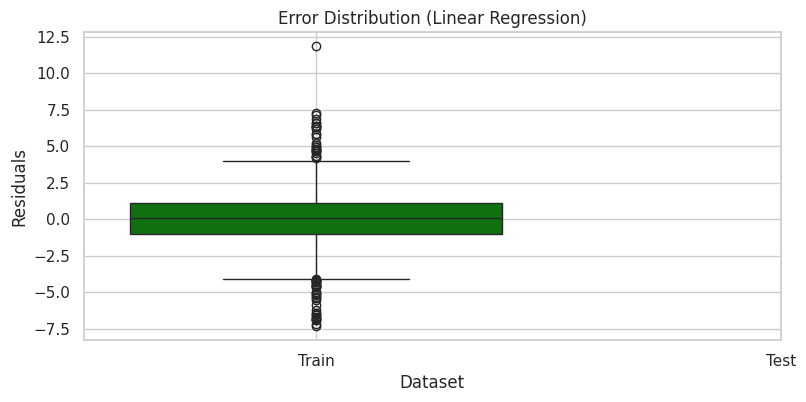

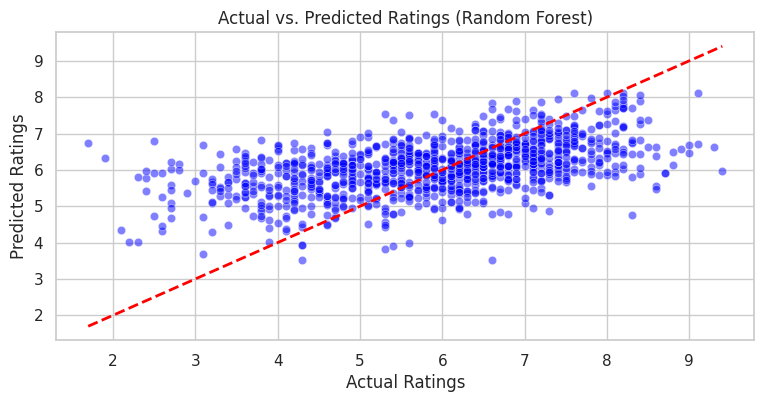

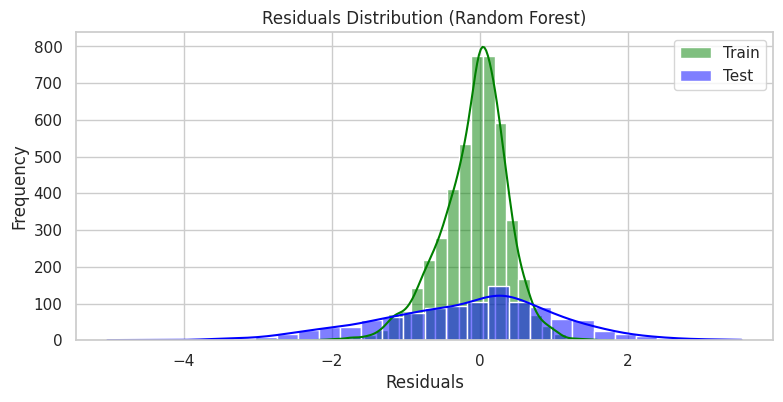

<ipython-input-1-b5b2e0312bdd>:107: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[residuals_train, residuals_test], palette=['green', 'blue'])


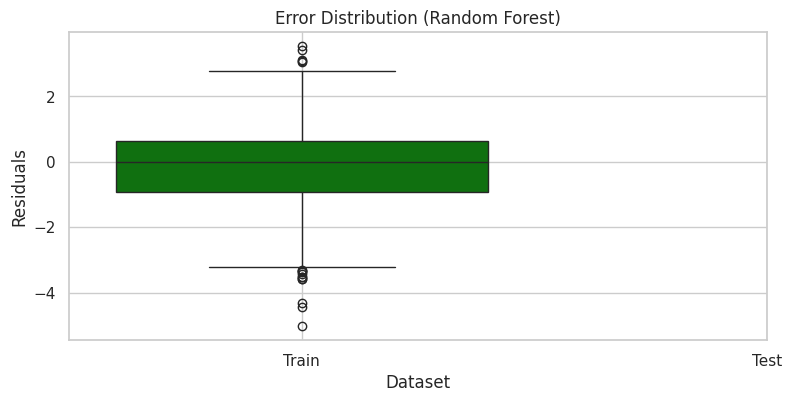

<ipython-input-1-b5b2e0312bdd>:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


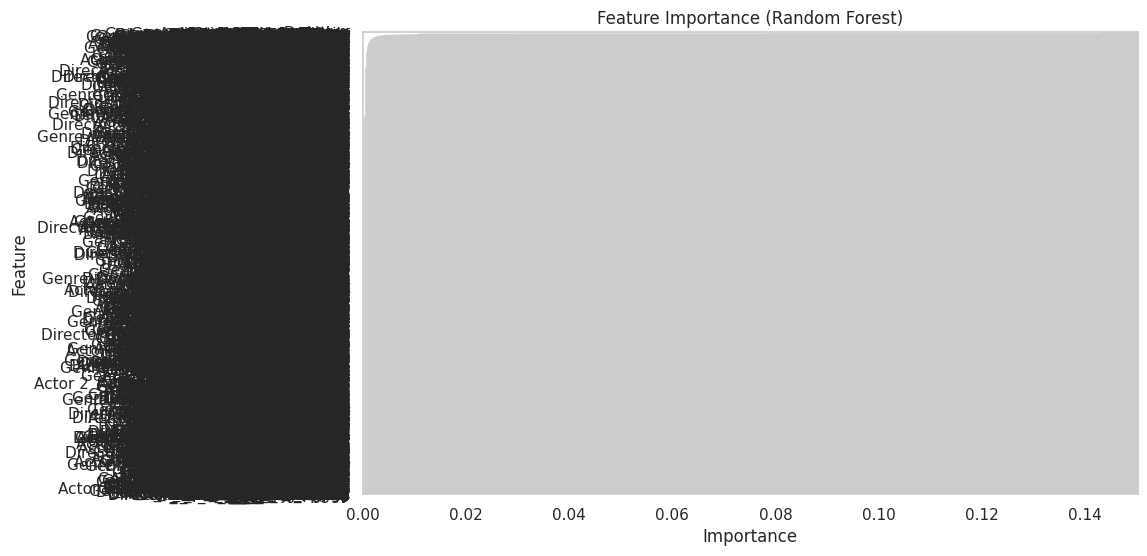

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Function to load and preprocess the dataset
def load_and_preprocess_data(file_path):
    # Load the dataset
    data = pd.read_csv(file_path, encoding='Latin-1')

    # Drop rows with missing values in important columns
    data.dropna(subset=['Rating', 'Genre', 'Director', 'Actor 1', 'Actor 2', 'Votes', 'Duration'], inplace=True)

    # Convert 'Duration' column to numeric (minutes)
    data['Duration'] = data['Duration'].apply(lambda x: int(re.search(r'\d+', x).group()) if pd.notnull(x) else np.nan)

    # Remove commas from 'Votes' column and convert to numeric
    data['Votes'] = data['Votes'].apply(lambda x: int(x.replace(',', '')) if pd.notnull(x) else np.nan)

    return data

# Function to train and evaluate the model
def train_and_evaluate_model(data):
    # Extract features and target variable
    X = data[['Genre', 'Director', 'Actor 1', 'Actor 2', 'Votes', 'Duration']]
    y = data['Rating']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['Genre', 'Director', 'Actor 1', 'Actor 2']),
            ('num', StandardScaler(), ['Votes', 'Duration'])
        ])

    # Define the models
    models = {
        'Linear Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                             ('regressor', LinearRegression())]),
        'Random Forest': Pipeline(steps=[('preprocessor', preprocessor),
                                         ('regressor', RandomForestRegressor(random_state=42))])
    }

    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
        test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
        r2 = r2_score(y_test, y_pred_test)
        results[name] = {'model': model, 'train_rmse': train_rmse, 'test_rmse': test_rmse, 'r2': r2, 'y_pred_test': y_pred_test, 'y_pred_train': y_pred_train}
        print(f"\n{name}")
        print(f"Train RMSE: {train_rmse}")
        print(f"Test RMSE: {test_rmse}")
        print(f"R2 Score: {r2}")

    return results, X_train, X_test, y_train, y_test

# Function to visualize the results
def visualize_results(y_train, y_test, results):
    # Set the Seaborn style
    sns.set(style="whitegrid")

    for name, result in results.items():
        y_pred_train = result['y_pred_train']
        y_pred_test = result['y_pred_test']

        # Plot actual vs. predicted ratings
        plt.figure(figsize=(9, 4))
        sns.scatterplot(x=y_test, y=y_pred_test, color='blue', alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2)
        plt.title(f'Actual vs. Predicted Ratings ({name})')
        plt.xlabel('Actual Ratings')
        plt.ylabel('Predicted Ratings')
        plt.grid(True)
        plt.show()

        # Calculate residuals (difference between actual and predicted ratings)
        residuals_test = y_test - y_pred_test
        residuals_train = y_train - y_pred_train

        # Plot residuals distribution
        plt.figure(figsize=(9, 4))
        sns.histplot(residuals_train, kde=True, color='green', bins=30, alpha=0.5, label='Train')
        sns.histplot(residuals_test, kde=True, color='blue', bins=30, alpha=0.5, label='Test')
        plt.title(f'Residuals Distribution ({name})')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot error distribution
        plt.figure(figsize=(9, 4))
        sns.boxplot(data=[residuals_train, residuals_test], palette=['green', 'blue'])
        plt.xticks([0, 1], ['Train', 'Test'])
        plt.title(f'Error Distribution ({name})')
        plt.xlabel('Dataset')
        plt.ylabel('Residuals')
        plt.grid(True)
        plt.show()

        if name == 'Random Forest':
            # Plot feature importances for Random Forest
            feature_importances = result['model'].named_steps['regressor'].feature_importances_
            feature_names = result['model'].named_steps['preprocessor'].transformers_[0][1].get_feature_names_out().tolist() + ['Votes', 'Duration']
            feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
            feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
            plt.title('Feature Importance (Random Forest)')
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.grid(True)
            plt.show()

# Main function
def main():
    # Replace 'your_dataset_path.csv' with the path to your dataset
    file_path = '/content/movies_datasetsnew.csv'
    data = load_and_preprocess_data(file_path)
    results, X_train, X_test, y_train, y_test = train_and_evaluate_model(data)
    visualize_results(y_train, y_test, results)

# Execute the main function
if __name__ == "__main__":
    main()
